<br><br>
<font size='6'><b>Recurrent Neural Network
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Recurrent Neural Network (RNN)
- RNNs are a family of neural networks for processing sequential data

## 1.1. Feedforward Network and Sequential Data

<br>
<img src="./image_files/sequence_layer.jpg" width = 400>
<br>

- Separate parameters for each value of the time index
    - Cannot share statistical strength across different time index

## 1.2. Structure of RNN

__ Recurrence __
- It is possible to use the __same__ transition function $f$ with the same parameters at every time step

<br>
<img src="./image_files/sequence_layer_dependv2.jpg" width = 370>
<br>

__ Hidden State __
- Lossy summary of the the past sequence of inputs up to $t$
- Keep some aspects of the past sequence with more precision than other aspects
- Network learns the function $f$
$$  h^{(t)} = f\left(h^{(t-1)}, x^{(t)}\right) $$
$$ f\left(h^{(t-1)}, x^{(t)}\right) = g\left(Wx_{t} + Uh_{t-1}\right) $$



<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
<img src="./image_files/micro_view_rnn.jpg" width = 400>
        </td>
        <td width = 48%>
<img src="./image_files/recurrence_gif.gif" width = 400>
        </td>
    </tr>
</table>
<br>

__ Deep Recurrent Networks __
- Three blocks of parameters and associated transformation
    1. From the input to the hidden state (from green to yellow)
    2. From the previous hidden state to the next hidden state (from yellow to red)
    3. From the hidden state to the output (from red to blue)
    
<br>
<img src="./image_files/deep_RNN.PNG" width = 300>
<br>

## 1.3. Training RNN

__ Long-Term Dependencies __
- Gradients propagated over many stages tend to either vanish or explode
- Difficulty with long-term dependencies arises from the exponentially smaller weights given to long-term interactions

<br>
<img src="./image_files/vanishing_gradient.jpg" width = 550>
<br>

__ Long Short-Term Memory (LSTM) __
- Allow the network to __accumulate__ information over a long duration
- Once that information has been used, it might be use for the neural network to __forget__ the old state

<br>
<img src="./image_files/gates_lstm.png" width = 550>
<br>

__ Summary __
- Connect LSTM cell in recurrent manner
- Train parameters in LSTM cell

<br>
<img src="./image_files/rnn_both.png" width = 900>
<br>


# 2. RNN with Tensorflow

- Will predict future time signal
- Regression problem

## 2.1. Import Library

In [1]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt

## 2.2. Load Time Signal Data
- Import acceleration signal of rotation machinery

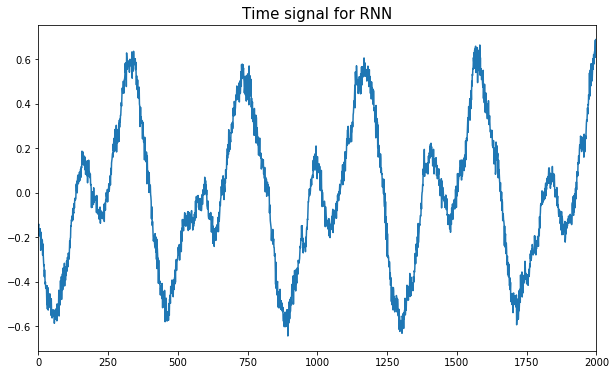

In [4]:
data =  cPickle.load(open('./data_files/rnn_time_signal.pkl', 'rb'))

plt.figure(figsize=(10,6))
plt.title('Time signal for RNN', fontsize=15)
plt.plot(data[0:2000])
plt.xlim(0,2000)
plt.show()

## 2.3. Define RNN Shape

<br>
<img src="./image_files/RNN_ac.png" width = 650>
<br>

In [5]:
n_step = 25
n_input = 100
n_output = 100

## LSTM shape
n_hidden1 = 100
n_hidden2 = 100

## Fully connected
n_hidden3 = 100

## 2.4. Define Weights and Biases

__LSTM Cell__
- Do not need to define weights of lstm cell

__ Fully connected__
- Define parameters based on predefined layer size
- Initialize with normal distribution with $\mu = 0$ and $\sigma = 0.01$


In [6]:
weights = {
    'W1' : tf.Variable(tf.random_normal([n_hidden2, n_hidden3], stddev=0.01)),
    'W2' : tf.Variable(tf.random_normal([n_hidden3, n_output], stddev=0.01))
}
biases = {
    'b1' : tf.Variable(tf.random_normal([n_hidden3], stddev=0.01)),
    'b2' : tf.Variable(tf.random_normal([n_output], stddev=0.01))
}

## 2.5. Build Model

__ Build RNN Network __
- First, define LSTM cell
```python
lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden)
```
- Second, compute hidden state (h) and lstm cell (c) with predefined lstm cell and input
```python
h, c = tf.nn.dynamic_rnn(lstm, input_tensor, dtype=tf.float32)
```

In [7]:
def net(x, weights, biases):
    with tf.variable_scope('rnn'):
        # Build RNN network
        with tf.variable_scope('lstm1'):
            #rnn_cell1 = tf.contrib.rnn.BasicRNNCell(n_hidden1)
            lstm1 = tf.contrib.rnn.BasicLSTMCell(n_hidden1)
            h1, c1 = tf.nn.dynamic_rnn(lstm1, x, dtype=tf.float32)
        with tf.variable_scope('lstm2'):
            #rnn_cell2 = tf.contrib.rnn.BasicRNNCell(n_hidden2)
            lstm2 = tf.contrib.rnn.BasicLSTMCell(n_hidden2)
            h2, c2 = tf.nn.dynamic_rnn(lstm2, h1, dtype=tf.float32)
            
        # Build classifier
        hidden = tf.matmul(h2[:, -1, :], weights['W1']) + biases['b1']
        hidden = tf.nn.relu(hidden)
        pred = tf.matmul(hidden, weights['W2']) + biases['b2']
        return pred

## 2.6. Define Cost, Initializer and Optimizer
__Loss__

- Regression : Squared loss
$$  \sum_{i=1}^{N=25}  (h_{\theta}\left(x^{(i)}\right) - y^{(i)})^2$$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer : The most popular optimizer

In [8]:
learning_rate = 0.0001
x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

pred = net(x, weights, biases)
cost = tf.reduce_mean(tf.square(y - pred))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

## 2.7. Summary of Model

<br>
<img src="./image_files/cnn_summary of model.png" width = 500>
<br>

## 2.7. Define Configuration

- Define parameters for training RNN
     - Number of iteration : number of training steps
     - Flag : check cost for every flag iteration

In [9]:
n_iter = 5000
flag = 250
stride = 5

## 2.8. Optimize

In [10]:
sess = tf.Session()
sess.run(init)

for i in range(n_iter):
    batch_x = data[i*stride:i*stride + n_step*n_input]
    batch_x = batch_x.reshape(n_step, n_input)
    batch_x = batch_x[np.newaxis, :]
    
    batch_y = data[i*stride + n_step*n_input:i*stride + n_step*n_input + n_output]
    batch_y = batch_y[np.newaxis, :]
    
    sess.run(optimizer, feed_dict={x: batch_x,  y: batch_y})
    c = sess.run(cost, feed_dict={x: batch_x,  y: batch_y})
    if i % flag == 0:
        print ("Iter : {}".format(i))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.18622340261936188
Iter : 250
Cost : 0.19345888495445251
Iter : 500
Cost : 0.2420896291732788
Iter : 750
Cost : 0.18156713247299194
Iter : 1000
Cost : 0.192257821559906
Iter : 1250
Cost : 0.026156703010201454
Iter : 1500
Cost : 0.005892727058380842
Iter : 1750
Cost : 0.004972219001501799
Iter : 2000
Cost : 0.003566770814359188
Iter : 2250
Cost : 0.01876230724155903
Iter : 2500
Cost : 0.0039002210833132267
Iter : 2750
Cost : 0.0014713548589497805
Iter : 3000
Cost : 0.012844132259488106
Iter : 3250
Cost : 0.01638888381421566
Iter : 3500
Cost : 0.0067461589351296425
Iter : 3750
Cost : 0.004666176624596119
Iter : 4000
Cost : 0.004076256882399321
Iter : 4250
Cost : 0.0019081940408796072
Iter : 4500
Cost : 0.006109113339334726
Iter : 4750
Cost : 0.016078965738415718


## 2.9. Test
- Generate future time signal

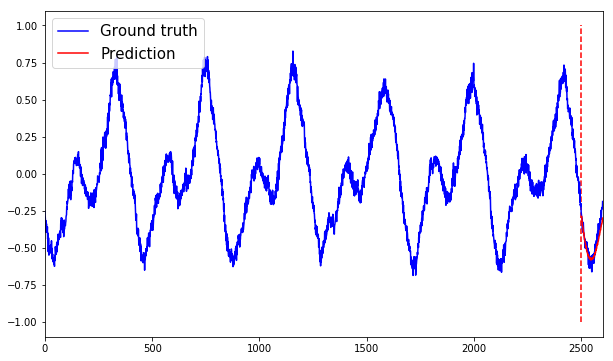

In [12]:
test_x = data[10000:10000 + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[10000:10000 + n_step*n_input + n_input]

test_pred = sess.run(pred, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_input), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(n_step*n_input, n_step*n_input + n_input), test_pred.ravel(), 'r', label='Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(0, len(ground_truth))
plt.show()


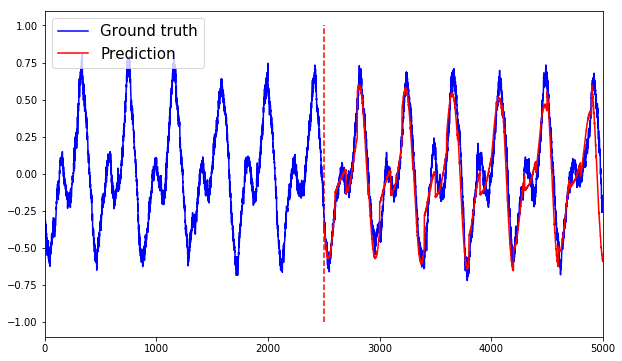

In [17]:
test_x = data[10000:10000 + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[10000:10000 + n_step*n_input + n_step*n_input]

gen_signal = []
for i in range(n_step):
    test_pred = sess.run(pred, feed_dict={x : test_x})
    gen_signal.append(test_pred.ravel())
    test_pred = test_pred[:, np.newaxis, :]
    
    test_x = test_x[:, 1:, :]
    test_x = np.concatenate([test_x, test_pred], axis=1)
    
gen_signal = np.concatenate(gen_signal)

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_step*n_input), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(n_step*n_input,  n_step*n_input + n_step*n_input), gen_signal, 'r', label='Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(0, len(ground_truth))
plt.show()

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>